## Setup and Data

In [1]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import numpy as np
from pynhd import NLDI
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.plot import reshape_as_image
import tomli
import xarray as xr

from landscape_processes.data_functions import get_aligned_input_rasters
from landscape_processes.raster_utils import load_raster_xr
from landscape_processes.terrain import derived_terrain_rasters
from landscape_processes.thresholds import compute_channelization_raster
from landscape_processes.thresholds import compute_landsliding_raster
from landscape_processes.thresholds import compute_saturated_raster
from landscape_processes.thresholds import unconditionally_stable
from landscape_processes.thresholds import unconditionally_unstable

In [2]:
geom_crs = "EPSG:4326"
crs = "EPSG:5070"

basin = NLDI().get_basins(feature_ids='11376550', fsource="ca_gages")
basin = basin.to_crs(geom_crs)
geom = basin.geometry[0]

In [3]:
dem, t, bd, p = get_aligned_input_rasters(geom, geom_crs=geom_crs, crs=crs, wet=True)

## Visualize the Input Rasters

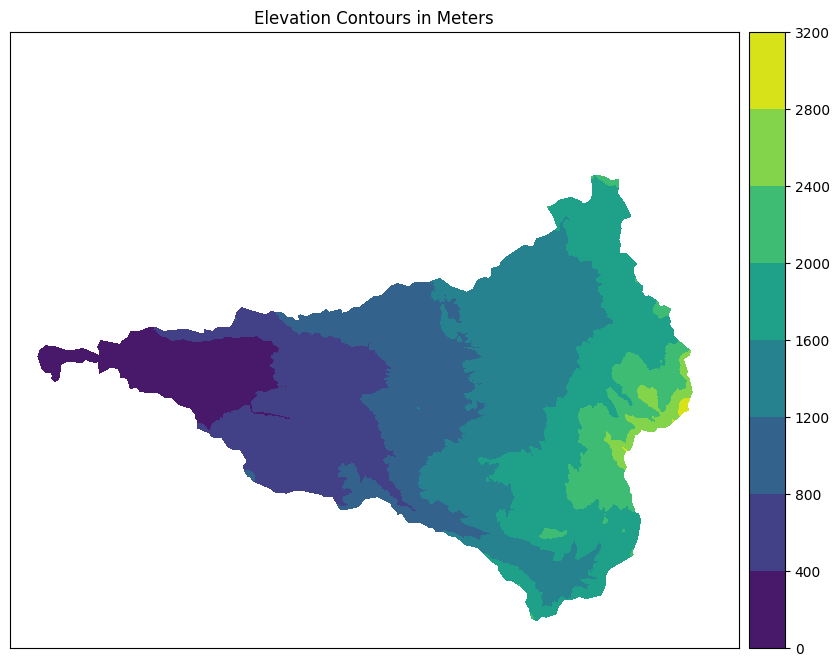

In [4]:
# DEM
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)
cs = ax.contourf(dem, origin="upper")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Elevation Contours in Meters")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(cs, cax=cax, orientation="vertical")
plt.show()

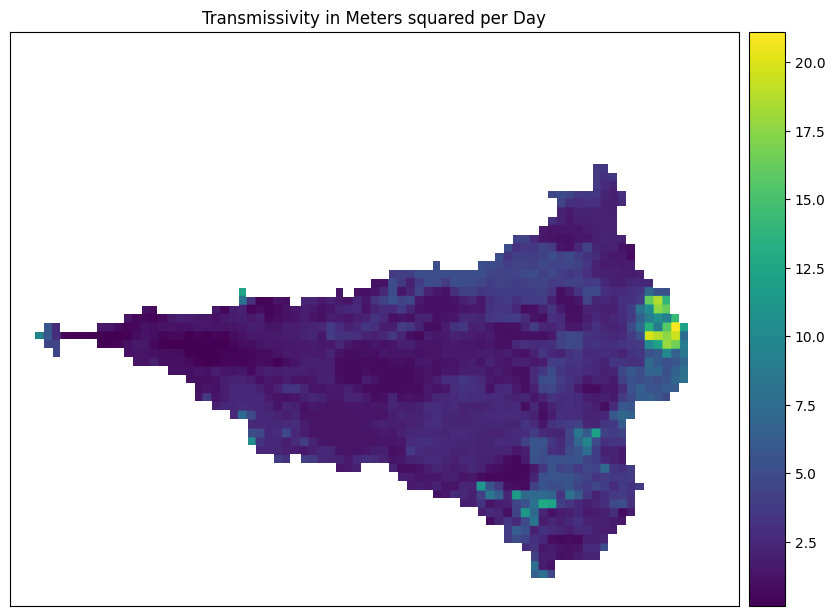

In [5]:
# Transmissivity
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)

cs = ax.imshow(t, origin="upper")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Transmissivity in Meters squared per Day")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(cs, cax=cax, orientation="vertical")
plt.show()

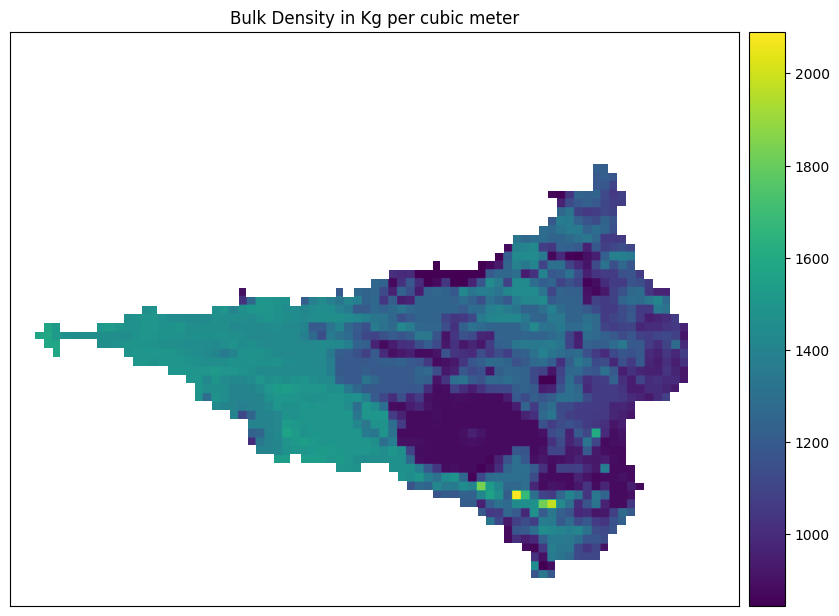

In [6]:
# Particle Bulk Density
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)

cs = ax.imshow(bd, origin="upper")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Bulk Density in Kg per cubic meter")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(cs, cax=cax, orientation="vertical")
plt.show()

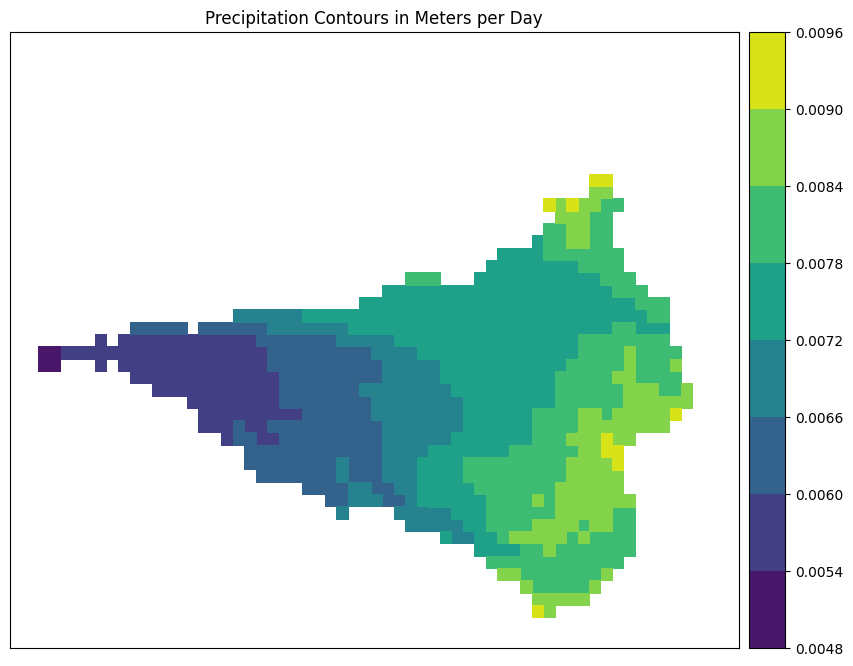

In [7]:
# Precipitation
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)
cs = ax.contourf(p, origin="upper")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Precipitation Contours in Meters per Day")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(cs, cax=cax, orientation="vertical")
plt.show()

## Visualize Derived Terrain Rasters

In [11]:
import os

import numpy as np
import richdem as rd
import xarray 
import xrspatial as xrs

from landscape_processes.raster_utils import load_raster_xr

def compute_slope_xr(dem):
    slope = xrs.slope(dem)
    return slope

def compute_accumulation(elevation):
    # save to temp file
    temp_file = 'temp.tif'
    elevation.rio.to_raster(temp_file)

    # load dem with rd
    dem = rd.LoadGDAL(temp_file)
    nan = np.isnan(dem)
    rd.FillDepressions(dem, epsilon=True, in_place=True)
    flow_accum = rd.FlowAccumulation(dem, method='D8')
    flow_accum[nan] = np.nan
    os.remove(temp_file)

    # convert to xarray
    rd.SaveGDAL(temp_file, flow_accum)
    flow_accum = load_raster_xr(temp_file)
    os.remove(temp_file)
    return flow_accum

# a: contributing area (area of each cell that flows into a given cell)
# b: width of each cell
def compute_a_over_b(flow_accum):
    # pixel width in meters
    pw = abs(flow_accum.rio.resolution()[0])
    # pixel hieght in meters
    ph = abs(flow_accum.rio.resolution()[1])

    area = pw*ph
    a = flow_accum * area
    b = pw

    with xarray.set_options(keep_attrs=True):
        ab = a/b
    return ab

def derived_terrain_rasters(elevation):
    theta = compute_slope_xr(elevation)
    M = np.sin(theta)
    flow_accum = compute_accumulation(elevation)
    a_over_b = compute_a_over_b(flow_accum)

    return theta, M, flow_accum, a_over_b

In [12]:
theta, M, fa, a_over_b = derived_terrain_rasters(dem)


A Priority-Flood+Epsilon
C Barnes, R., Lehman, C., Mulla, D., 2014. Priority-flood: An optimal depression-filling and watershed-labeling algorithm for digital elevation models. Computers & Geosciences 62, 117–127. doi:10.1016/j.cageo.2013.04.024

c topology = D8
p Setting up boolean flood array matrix...
p Adding cells to the priority queue...
p Performing Priority-Flood+Epsilon...
t succeeded in 4.03604 s
m Cells processed = 34648380
m Cells in pits = 78256



A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 27977384
p Calculating flow accumulation...
t Wall-time       = 1.35166 s


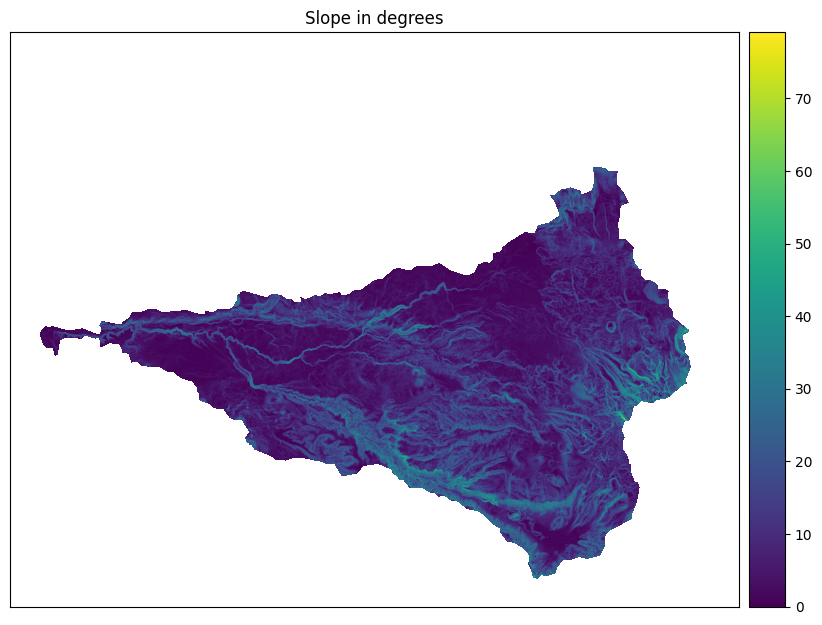

In [32]:
# Theta (Slope angle)
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)

cs = ax.imshow(theta, origin="upper")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Slope in degrees")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(cs, cax=cax, orientation="vertical")
plt.show()

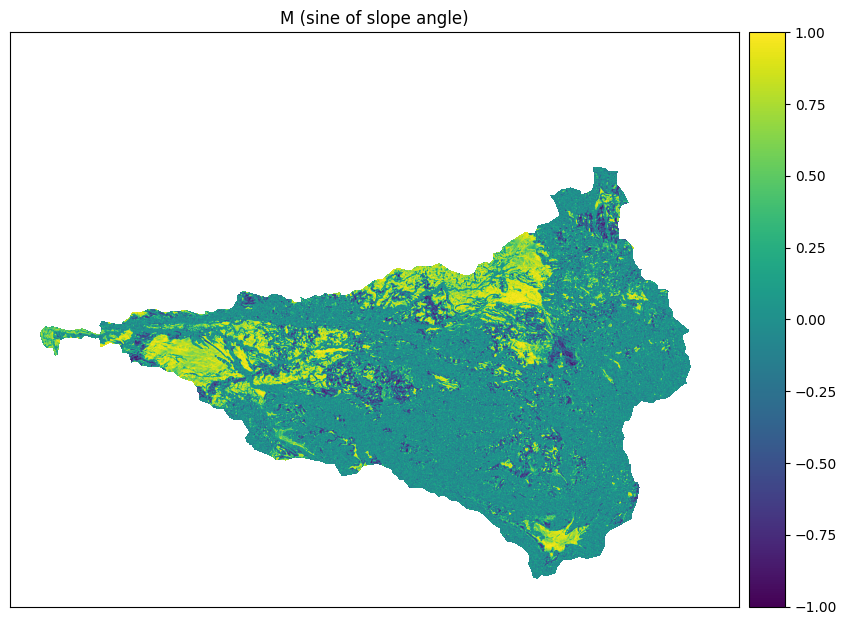

In [33]:
# M (sine of theta)
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)

cs = ax.imshow(M, origin="upper")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("M (sine of slope angle)")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(cs, cax=cax, orientation="vertical")
plt.show()

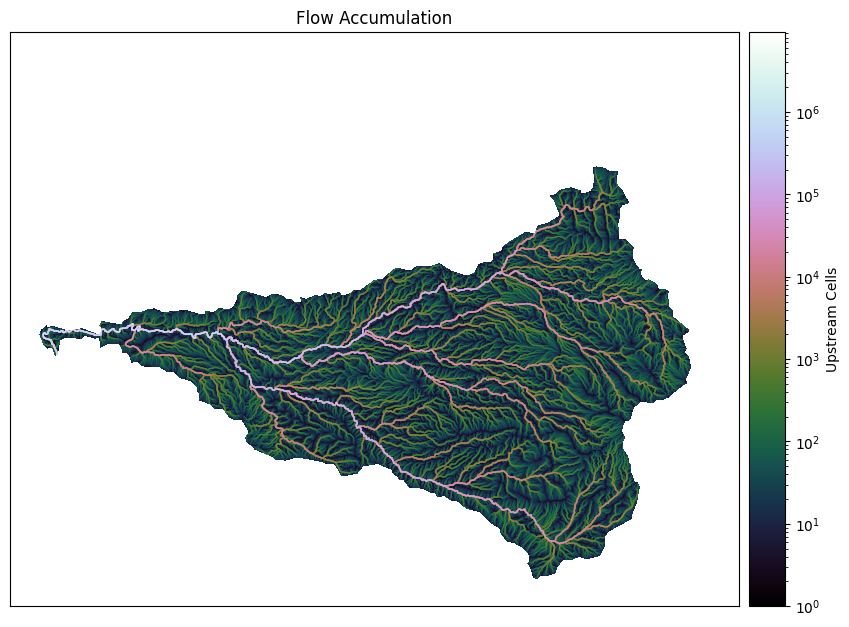

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
divider = make_axes_locatable(ax)
fig.patch.set_alpha(0)
im = ax.imshow(fa,  zorder=2,
               cmap='cubehelix',
               norm=matplotlib.colors.LogNorm(1, fa.max()),
               interpolation='bilinear')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Flow Accumulation")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation="vertical", label="Upstream Cells")
plt.show()

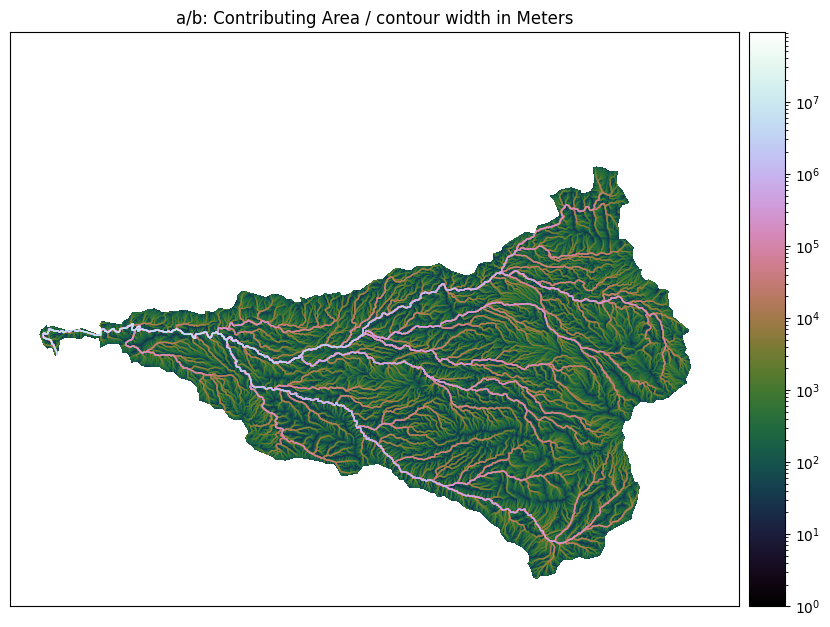

In [36]:
# a over b
fig, ax = plt.subplots(figsize=(10,8))
divider = make_axes_locatable(ax)
fig.patch.set_alpha(0)
im = ax.imshow(a_over_b,  zorder=2,
               cmap='cubehelix',
               norm=matplotlib.colors.LogNorm(1, a_over_b.max()),
               interpolation='bilinear')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("a/b: Contributing Area / contour width in Meters")
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im, cax=cax, orientation="vertical")
plt.show()